# T2* map calculation tutorial

Start by importing the required libraries and defining some settings:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from ukat.data import fetch
from ukat.mapping.t2star import T2Star

# Ensure figures are rendered in the notebook
%matplotlib inline

Tell python where to store the T2* maps NIfTI files we will generate. We will store it in a directory called `t2star_calculation_output` in the `tutorials` directory.

In [2]:
# Initialise output path for T2star map
directory = 't2star_calculation_output'
os.makedirs(directory, exist_ok=True)
OUTPUT_DIR = os.path.join(os.getcwd(), directory)

Retrieve T2* test data using our data fetcher. The first time the fetcher is run, it will download the data from the
internet, after that it will just use the cached local data.

This will return 3 variables:
* `image`: a 4D array with the magnitude data at all echo times.
* `affine`: the affine matrix for the data (needed to later write a new NIfTI file).
* `te`: an array containing the echo times, in seconds.

In [3]:
# Fetch test data
image, affine, te = fetch.t2star_philips()
te = te * 1000  # convert TE to ms

Compute the T2* maps using the `T2Star` class implemented in `mapping`. We'll start with the logarithmic linear fitting
method (`loglin`).

In [4]:
# Initialise the loglin mapping object
mapper_loglin = T2Star(image, te, affine=affine, method='loglin')

# Extract the T2* map from the object
t2star_loglin = mapper_loglin.t2star_map

# Save output maps to Nifti
mapper_loglin.to_nifti(output_directory=OUTPUT_DIR, maps=['m0', 't2star'], base_file_name='Philips_loglin')

  0%|          | 0/81920 [00:00<?, ?it/s]D:\ppxad2\ownCloud\University\Renal Imaging\ukat\ukat\mapping\t2star.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  t2star = np.real(-1 / b)
100%|██████████| 81920/81920 [00:08<00:00, 9148.51it/s] 


Now we're going to calculate the T2* map using the two parameter exponential curve fitting method (`2p_exp`). This method
takes quite a lot longer but is more accurate for T2* less than 20 ms such as in the liver.

In [5]:
# Initialise the loglin mapping object
mapper_2p_exp = T2Star(image, te, affine=affine, method='2p_exp')

# Extract the T2* map from the object
t2star_2p_exp = mapper_2p_exp.t2star_map

# Save output maps to Nifti
mapper_2p_exp.to_nifti(output_directory=OUTPUT_DIR, maps=['m0', 't2star'], base_file_name='Philips_2p_exp')

100%|██████████| 81920/81920 [03:45<00:00, 363.51it/s] 


Display a central slice of the T2* maps and the difference between them. Note the units are _ms_.

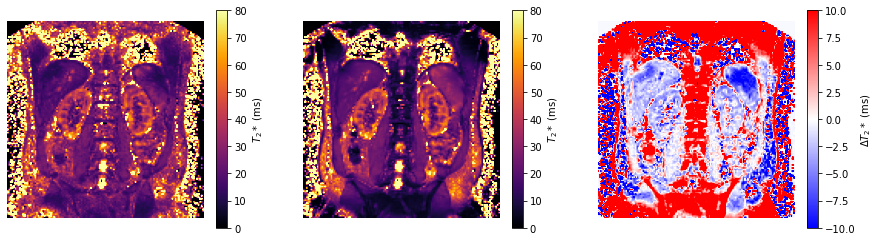

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Display a central slice of the log linear T2* map
im = ax1.imshow(np.rot90(t2star_loglin[:, :, 2]), cmap='inferno', clim=(0, 80))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('$T_2*$ (ms)')
ax1.axis('off')

# Display a central slice of the exponential curve fit T2* map
im = ax2.imshow(np.rot90(t2star_2p_exp[:, :, 2]), cmap='inferno', clim=(0, 80))
cb = fig.colorbar(im, ax=ax2)
cb.set_label('$T_2*$ (ms)')
ax2.axis('off')

# Display the difference between the two mapping methods
im = ax3.imshow(np.rot90(t2star_loglin[:, :, 2] - t2star_2p_exp[:, :, 2]), cmap='bwr', clim=(-10, 10))
cb = fig.colorbar(im, ax=ax3)
cb.set_label('$\Delta T_2*$ (ms)')
ax3.axis('off')

plt.show()

We can also view the corresponding R2* map.

D:\ppxad2\ownCloud\University\Renal Imaging\ukat\ukat\mapping\t2star.py:263: RuntimeWarning: divide by zero encountered in reciprocal
  r2star = np.reciprocal(self.t2star_map)


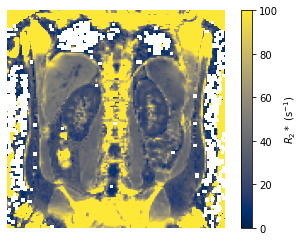

In [7]:
r2star_2p_exp = mapper_2p_exp.r2star_map()

fig, ax = plt.subplots()
im = ax.imshow(np.rot90(r2star_2p_exp[:, :, 2] * 1000), cmap='cividis', clim=(0, 100))
cb = fig.colorbar(im)
cb.set_label('$R_2*$ (s$^{-1})$')
ax.axis('off')
plt.show()